# Lab 5 - Multivariate Regression, Non-Parametric Models and Cross-Validation

**Name: Chen, Kun**

**ID: 8977010**

### 0. Import the library

In [18]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import datasets
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.datasets import load_diabetes

### 1. Load Dataset

In [19]:
data, target = datasets.load_diabetes(return_X_y=True, as_frame=True, scaled=True)

temp = datasets.load_diabetes(scaled=False)
diabetes= pd.DataFrame(data=np.c_[temp['data'], temp['target']],
                     columns=temp['feature_names'] + ['target'])
diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


### 2. EDA

#### a) Print a concise summary of a DataFrame.

In [20]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


#### b) Check that the dataset contains invalid data and drop the duplicate data

In [21]:
diabetes.isnull().to_numpy().all()
diabetes = diabetes.dropna()
diabetes = diabetes.drop_duplicates()
diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


#### c) Plot a heat map of correlation

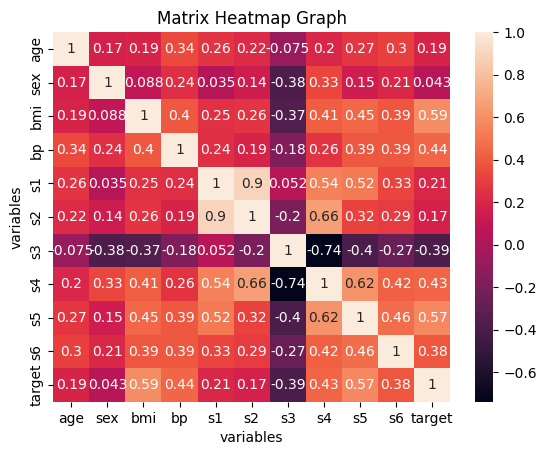

In [22]:
sn.heatmap(diabetes.corr(), annot=True)
plt.title('Matrix Heatmap Graph')
plt.xlabel('variables') 
plt.ylabel('variables')
plt.show()

#### d) We can see that the gender data has a weak correlation with target (0.043) and it can be droped

In [23]:
x = np.array(data)
y = np.array(target)

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 - train_ratio, shuffle=True, random_state=77)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=True, random_state=33) 

### 3. Perform cross-validation for different kind models to find the best fit model

In [24]:
poly_models = {}
for degree in [3, 8]:
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(x_train)
    poly_models[f'Polynomial {degree}'] = LinearRegression()

decision_tree_models = {}
for max_depth in [3, 4]:
    decision_tree_models[f'Decision Tree {max_depth}'] = DecisionTreeRegressor(max_depth=max_depth)

knn_models = {}
for n_neighbors in [3, 5]:
    knn_models[f'kNN {n_neighbors}'] = KNeighborsRegressor(n_neighbors=n_neighbors)

models = {**poly_models, **decision_tree_models, **knn_models}

scoring = {'r2': make_scorer(r2_score),
           'mae': make_scorer(mean_absolute_error),
           'mape': make_scorer(mean_absolute_percentage_error)}

results = []
cv = KFold(n_splits=5, shuffle=True, random_state=1)
for name, model in models.items():
    model.fit(x_train, y_train)
    cv_results = cross_validate(model, x_train, y_train, scoring=scoring, cv=cv)
    r2_mean = cv_results['test_r2'].mean()
    r2_std = cv_results['test_r2'].std()
    mae_mean = cv_results['test_mae'].mean()
    mae_std = cv_results['test_mae'].std()
    mape_mean = cv_results['test_mape'].mean()
    mape_std = cv_results['test_mape'].std()
    results.append([name, r2_mean, r2_std, mae_mean, mae_std, mape_mean, mape_std])

columns = ['Model', 'R-Squared Mean', 'R-Squared Std', 'MAE Mean', 'MAE Std', 'MAPE Mean', 'MAPE Std']
results_df = pd.DataFrame(results, columns=columns)

print(results_df)

             Model  R-Squared Mean  R-Squared Std   MAE Mean   MAE Std  \
0     Polynomial 3        0.460561       0.054816  44.719984  4.044628   
1     Polynomial 8        0.460561       0.054816  44.719984  4.044628   
2  Decision Tree 3        0.266985       0.129553  52.299766  4.841045   
3  Decision Tree 4        0.227259       0.166026  52.272170  5.153582   
4            kNN 3        0.314657       0.154890  48.937317  6.793582   
5            kNN 5        0.389618       0.071469  47.282803  4.422569   

   MAPE Mean  MAPE Std  
0   0.401306  0.031729  
1   0.401306  0.031729  
2   0.452668  0.035024  
3   0.449995  0.026661  
4   0.421704  0.053876  
5   0.413114  0.036356  


Base on above result, KNN 5 is the best Model

In [25]:
knn_model = models['kNN 5']

y_pred_test = knn_model.predict(x_test)

r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print('Test Set Performance for kNN 5:')
print('R-Squared: %.3f' % r2_test)
print('MAE: %.3f' % mae_test)
print('MAPE: %.3f' % mape_test)

Test Set Performance for kNN 5:
R-Squared: 0.205
MAE: 48.367
MAPE: 42.634


### 4) Plot the Model graph
Because the model has 10 FEATURES, it is not possible to represent it in 2D graphics. After asking ChatGpt for help it was decided to use Model Performance Curves.

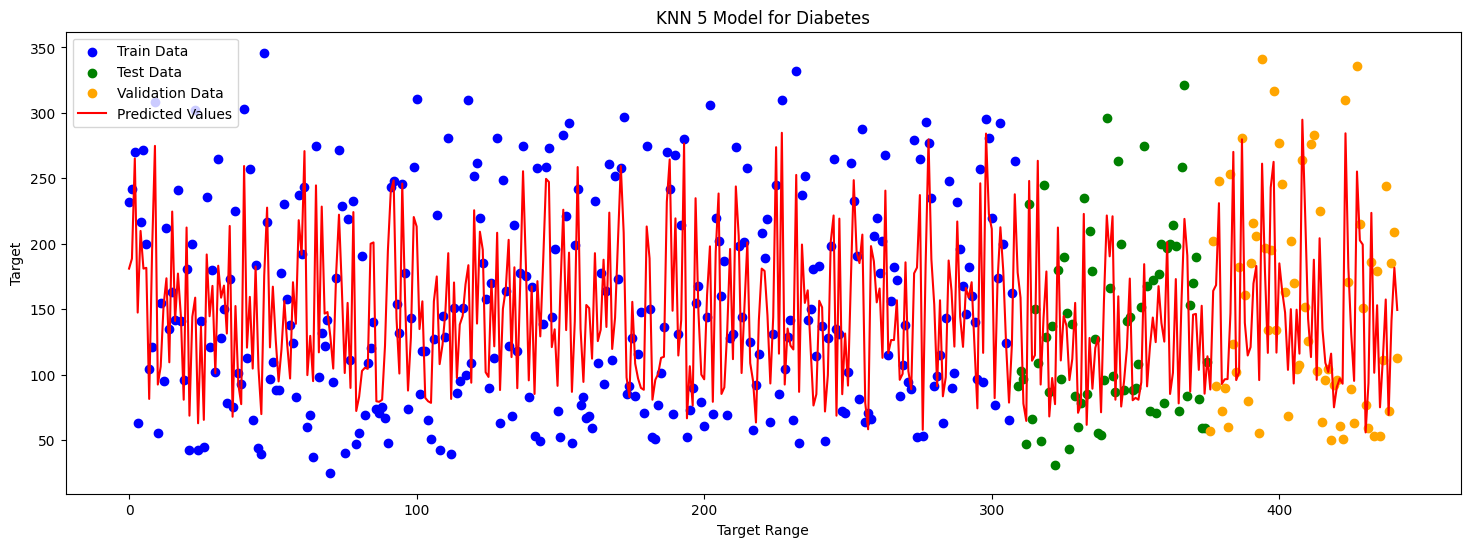

In [26]:
y_test_pred = knn_model.predict(x_test) 

plt.figure(figsize=(18, 6))

plt.scatter(range(len(y_train)), y_train, color='blue', label='Train Data')
plt.scatter(range(len(y_train), len(y_train) + len(y_test)), y_test, color='green', label='Test Data')
plt.scatter(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, color='orange', label='Validation Data')

all_y = np.concatenate((y_train, y_test, y_val))
predicted_values = knn_model.predict(np.concatenate((x_train, x_test, x_val)))
plt.plot(range(len(all_y)), predicted_values, color='red', label='Predicted Values')

plt.xlabel('Target Range')
plt.ylabel('Target')
plt.title('KNN 5 Model for Diabetes')
plt.legend()
plt.show()

### 5. Conclusion
We can see that the model does not fit the data well, and I think the main reason is that the model is too simple and does not fit the complex dataset well